<div style="background-color: #eee3d3">
<h1> 5-dimensionality_reduction.ipynb </h1>
</div>

---

# The purpose of this notebook is to use different methods to reduce 

- ## 1 - PCA (Principal Component Analysis
- ## 2 - Univariate feature selection ([link](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)) with ANOVA F-value
    - ### a - keep a specific number of features
    - ### b - keep all features with ANOVA pvalue $\lt \alpha
    - ### c - keep a specific percentile of features
- ## 3 - t-SNE
    - ### a - t-SNE on raw data
    - ### b - PCA then t-SNE
- ## 4 - UMAP
    - ### a - UMAP on raw data
    - ### b - PCA then UMAP
- ## (TODO) 5 - Recursive feature elimination
- ## (TODO) 6 - Feature selection using SelectFromModel
    
---

## References 

- Why normalisation : https://pubmed.ncbi.nlm.nih.gov/32276547/

- Sample normalisation : https://pubmed.ncbi.nlm.nih.gov/26763302/

# Import modules

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import SelectPercentile

from sklearn.preprocessing import LabelEncoder


import os

import cimcb_lite as cb

import time

In [63]:
import re
pwd = ! pwd
pwd = re.sub('notebooks', '', pwd[0])
print(f'Working directory : {pwd}')

import sys
sys.path.append(pwd + 'bin/')

from dimensionality_reduction_functions import *

Working directory : /home/jovyan/work/


In [64]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 15,10

sns.set_theme(style="darkgrid")

# Import data

In [65]:
path_peakTable = pwd + 'data/peakTable/chosen_imputed_normalised_peakTable/'
path_peakTable

'/home/jovyan/work/data/peakTable/chosen_imputed_normalised_peakTable/'

Below is the filename of the preprocessed peak table

In [66]:
filename_peakTable = [file for file in os.listdir(path_peakTable) if file.endswith('.csv')][0]
filename_peakTable

'peakTable-python_MICE_BayesianRidge-l2_normalisation-autoscaling.csv'

In [67]:
re.sub('.csv', '', filename_peakTable).split('-')[1:]

['python_MICE_BayesianRidge', 'l2_normalisation', 'autoscaling']

We can see the methods which have been used for imputation/normalisation/scaling :
- imputation method : python_MICE_BayesianRidge
- normalisation : l2_normalisation
- scaling : autoscaling

The following peak table has been imputed (we have no more missing values), normalised (sample-based) and scaled (metabolite-based) !

In [68]:
peakTable = pd.read_csv(path_peakTable + filename_peakTable, sep=',', decimal='.', na_values='NA')
peakTable['TypTumo'] = peakTable['TypTumo'].fillna('Non-case')
peakTable

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_5,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,0.343154,0.028213,...,0.677597,0.423164,-1.400209,0.240557,-2.650112,-0.450923,0.007627,-0.605720,-0.866681,-0.702342
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,0.514293,1.561149,...,-0.764355,0.082389,-1.691867,0.524777,0.312977,0.969049,0.987275,0.839022,-0.788942,-1.081942
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-0.966684,2.485037,...,-0.716359,-0.533313,-2.338208,-0.448139,-0.692877,-0.061555,-0.308102,-0.557681,-0.267428,0.021739
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-0.499471,2.294042,...,-0.623066,-0.511709,-0.896577,0.460528,-0.868587,-0.379402,-0.041673,-0.878755,-2.822468,-0.555637
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,0.789406,0.370597,...,-0.646925,-0.792683,0.113281,-0.301686,-0.091928,0.107454,-0.002273,0.534238,-0.757552,0.268754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,1.198158,0.236352,...,-0.711742,-1.595635,-0.141981,-0.366404,-1.113986,-3.361035,0.435091,-0.816180,0.084109,-0.001943
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-0.232292,1.056631,...,2.069408,0.135651,1.065614,-0.872576,0.369971,0.422004,-0.657858,1.670263,1.473349,1.106209
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,0.002991,0.066335,...,1.828458,1.319586,-0.752464,-0.255708,0.590072,3.012478,0.245043,0.309170,0.306393,0.128377
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.984124,0.429884,...,-0.772941,-0.673446,0.064045,-0.456010,-0.519668,-2.125012,0.127153,-1.784431,0.481025,0.137774


In [69]:
metadata = peakTable.iloc[:, ['variable' not in col for col in peakTable.columns]]
metadata

,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B
...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C


In [70]:
X = peakTable.iloc[:, ['variable' in col for col in peakTable.columns]]
X

,variable_3,variable_5,variable_6,variable_8,variable_10,variable_11,variable_14,variable_22,variable_23,variable_25,...,variable_2326,variable_2328,variable_2329,variable_2332,variable_2339,variable_2340,variable_2350,variable_2364,variable_2365,variable_2370
0,0.343154,0.028213,0.403068,-0.723907,0.292690,0.734648,0.454773,0.025521,1.727030,0.590418,...,0.677597,0.423164,-1.400209,0.240557,-2.650112,-0.450923,0.007627,-0.605720,-0.866681,-0.702342
1,0.514293,1.561149,-2.358937,-0.785405,-0.303024,-2.109607,0.907843,-0.497925,-0.408785,-2.637934,...,-0.764355,0.082389,-1.691867,0.524777,0.312977,0.969049,0.987275,0.839022,-0.788942,-1.081942
2,-0.966684,2.485037,0.902786,-0.487741,-0.951130,0.125416,0.549394,0.395810,0.009166,-0.094654,...,-0.716359,-0.533313,-2.338208,-0.448139,-0.692877,-0.061555,-0.308102,-0.557681,-0.267428,0.021739
3,-0.499471,2.294042,0.654866,0.200169,1.013887,1.022829,-0.895230,-0.509404,0.862195,1.225857,...,-0.623066,-0.511709,-0.896577,0.460528,-0.868587,-0.379402,-0.041673,-0.878755,-2.822468,-0.555637
4,0.789406,0.370597,1.186125,-1.139745,-0.288708,0.235699,-0.056561,-0.896501,0.840488,-0.160630,...,-0.646925,-0.792683,0.113281,-0.301686,-0.091928,0.107454,-0.002273,0.534238,-0.757552,0.268754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1.198158,0.236352,-1.742032,0.659971,-0.497824,-1.440565,0.410328,-1.211965,-1.165634,-1.536160,...,-0.711742,-1.595635,-0.141981,-0.366404,-1.113986,-3.361035,0.435091,-0.816180,0.084109,-0.001943
182,-0.232292,1.056631,-1.337454,-0.345675,-1.122356,-0.062979,0.072807,-0.389213,1.481026,-0.550822,...,2.069408,0.135651,1.065614,-0.872576,0.369971,0.422004,-0.657858,1.670263,1.473349,1.106209
183,0.002991,0.066335,-0.175633,0.289933,-0.957686,-0.848193,-0.211333,0.888016,-0.324560,-1.040175,...,1.828458,1.319586,-0.752464,-0.255708,0.590072,3.012478,0.245043,0.309170,0.306393,0.128377
184,-0.984124,0.429884,-1.131698,-0.712588,-1.491989,-2.069547,-0.398063,0.506517,0.733195,-2.292864,...,-0.772941,-0.673446,0.064045,-0.456010,-0.519668,-2.125012,0.127153,-1.784431,0.481025,0.137774


# Path to save reduced peak tables

In [71]:
path_peakTable_reduced = pwd + 'data/peakTable/reduced_peakTable/'
path_peakTable_reduced

'/home/jovyan/work/data/peakTable/reduced_peakTable/'

# 1 - PCA (Principal Component Analysis

### With PCA, we create new explanatory variables, which correspond to linear combination of initial features

### The objective of PCA is to keep as much initial variance as possible, while reducing the number of explanatory variables. One disadvantage is that the newly created variables have less concrete meaning than the initial ones.

In [72]:
'''
Perform PCA on a peak table

input :
    - X : peakTable with only variable columns, no metadata
    - n_components : number of components for the PCA
    - part_explained_variance : part of initial explained variance we want to keep in the reduced dimensions
    - concat_metadata (default=False) : if set to True, the returned dataframe df is concatenated with metadata passed as argument
    - metadata (default=None) : required if concat_metadata is set to True, corresponds to metadata dataframe
return :
    - df : dataframe with PCA components as columns and samples as rows
    - explained_variance : dataframe of % explained variance and cumulative sum for each component
plot :
    - lineplot of cumulative sum of explained variance
        x-axis : number of components
        y-axis : cumulative sum
'''
def perform_PCA(X, n_components=None, part_explained_variance=None, concat_metadata=False, metadata=None):
    
    
    # Apply StandardScaler() if not already done
    if (X.mean().mean() < 0.01) & (0.99 < X.std().mean() < 1.01):
        X_std = X
    else:
        X_std = StandardScaler().fit_transform(X)

    
    # Assertion
    assert not (isinstance(n_components, type(None)) and isinstance(part_explained_variance, type(None))),\
        '<n_components> or <part_explained_variance> has to be defined'
    
    assert (isinstance(n_components, type(None)) or isinstance(part_explained_variance, type(None))),\
        '<n_components> and <part_explained_variance> cannot be both passed as argument'
    
    if concat_metadata:
        # assert metadata != None
        assert not isinstance(metadata, type(None)),\
            'If <merge_metadata> is set to True, <metadata> has to be provided'
        
        
    # Perform PCA analysis
    if not isinstance(n_components, type(None)):
        PCA_model = PCA(n_components=n_components)
    else:
        PCA_model = PCA(n_components=part_explained_variance)
    principal_components = PCA_model.fit_transform(X_std)
    

    # Prepare column names
    col_names = ['PC' + str(i+1) for i in range(principal_components.shape[1])]
    index = X.index.values
    
    
    # Prepare df dataframe to return
    # Concat metadata if set to True
    if concat_metadata:
        subset = pd.concat([metadata, pd.DataFrame(principal_components, columns = col_names, index = index)], axis=1)
    else:
        subset = pd.DataFrame(principal_components, columns = col_names, index = index)
    
    # Get percent of explained variance
    explained_variance = PCA_model.explained_variance_ratio_
    explained_variance_format = [round(num, 2) for num in explained_variance * 100]

    # Compute cumulative sum of explained variance percents
    cum_sum = np.cumsum(explained_variance)
    cum_sum_format = [round(num, 2) for num in cum_sum * 100]
    
    # Prepare explained_variance dataframe to return
    explained_variance = pd.DataFrame(list(zip(explained_variance_format, cum_sum_format)), columns = [['Explained variance (%)', 'Cumulative sum']], index = col_names)
    
    
    # Plot cumulative sum of explained variance
    fig, ax = plt.subplots()
    xi = np.arange(1, explained_variance.shape[0] + 1, step=1)
    y = np.cumsum(PCA_model.explained_variance_ratio_)

    plt.ylim(0, 1.05)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')
    plt.text(x=PCA_model.n_components_, y=y[-1] + 0.03, s=f'PC{PCA_model.n_components_}\n({y[-1]*100:.2f}%)',
             color='b', fontsize=12)

    plt.xlabel('Number of Components', fontsize=14)
    plt.ylabel('Cumulative variance', fontsize=14)
    
    if not isinstance(n_components, type(None)):
        plt.title(f'Explained variance with {n_components} components in PCA model', fontsize=18)
    else:
        plt.title(f'The number of components needed to explain {part_explained_variance*100:.0f}% of total variance', fontsize=18)
        plt.axhline(y=part_explained_variance, color='r', linestyle='-')
        plt.text(x=0.5, y=part_explained_variance - 0.05, s=f'{part_explained_variance}% cut-off threshold', color='r', fontsize=12)

    plt.show()
    
    return subset, explained_variance

#### We can either pass the percent of explained variance that we want (below is 70%) and the function decide the number of components

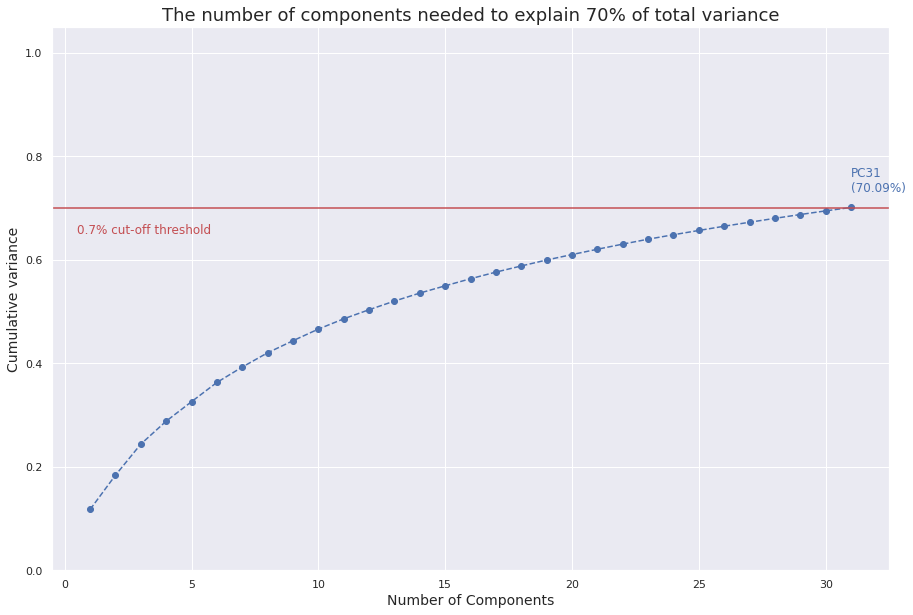

Initial number of dimension : 337
Final number of dimension : 31


,Explained variance (%),Cumulative sum
PC1,11.76,11.76
PC2,6.62,18.38
PC3,6.01,24.38
PC4,4.43,28.81
PC5,3.76,32.58
PC6,3.71,36.29
PC7,2.97,39.26
PC8,2.75,42.02
PC9,2.33,44.35
PC10,2.24,46.60


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,PC1,PC2,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,-12.372109,-2.043059,...,1.461407,4.244780,-0.249895,-0.925630,-0.780152,-2.054856,-0.757418,-4.515187,0.387069,0.563967
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-6.619444,-1.036887,...,-0.371352,1.965933,4.861848,-0.188043,-0.430698,-1.147008,-0.431699,1.541463,-0.369836,-0.929039
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-6.178319,-6.451937,...,-0.588610,3.636261,-0.148694,1.611710,-1.298399,-2.136407,-3.372794,1.661457,-1.141111,-1.827403
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-9.124357,-6.556480,...,-1.340590,2.463347,-2.223353,0.344023,-0.784697,-2.540689,-1.521398,-0.062131,-1.753967,0.281867
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-4.229493,-10.779293,...,0.913470,-0.107138,-0.543639,-0.569719,1.502887,-3.615806,-1.153048,0.075981,-2.185504,-2.383102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,1.803461,1.922454,...,-1.611530,4.978986,-1.609048,-3.024519,3.154007,-0.143627,-2.207852,-2.676008,1.803767,1.844707
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,1.824354,10.298834,...,2.406762,2.778722,1.489667,-2.285347,0.060081,-0.987799,0.283471,-1.528250,-0.532753,-1.249068
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,8.827928,2.809567,...,-0.140333,0.401475,-0.574732,2.496982,-1.060755,0.834660,0.330676,-1.450272,0.330975,0.102053
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,3.359106,6.859640,...,-2.265300,4.555769,-3.016074,0.366485,0.410747,0.371338,-1.080834,0.168764,1.281802,0.005730


In [174]:
X_subset, explained_variance = perform_PCA(X, part_explained_variance=0.7, concat_metadata=True, metadata=metadata)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(explained_variance)
display(X_subset)

In [175]:
filename = 'peakTable-PCA_70percent.csv'
X_subset.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-PCA_70percent.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


#### Or direclty the number of components

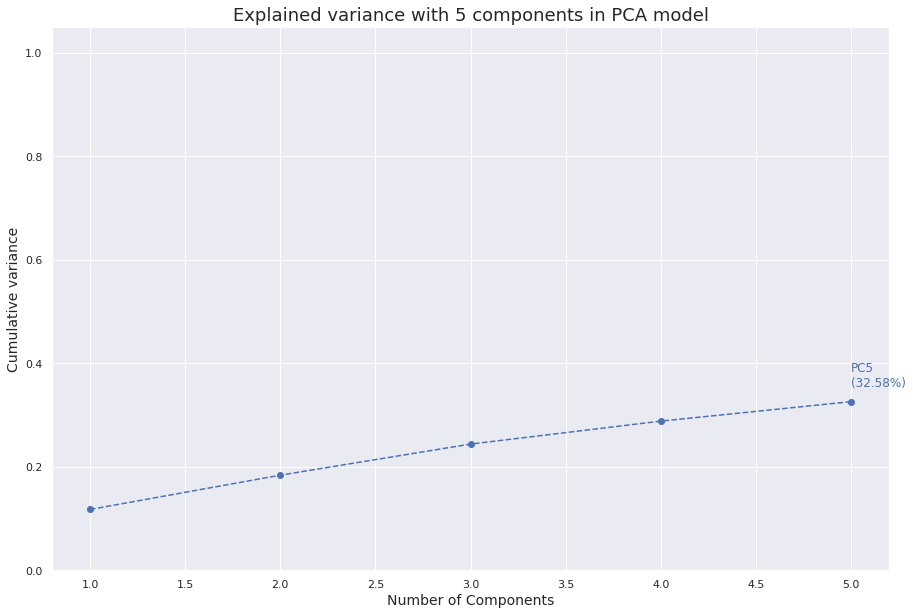

Initial number of dimension : 337
Final number of dimension : 5


,Explained variance (%),Cumulative sum
PC1,11.76,11.76
PC2,6.62,18.38
PC3,6.01,24.38
PC4,4.43,28.81
PC5,3.76,32.58


,PC1,PC2,PC3,PC4,PC5
0,-12.372109,-2.043059,-3.261698,0.430363,4.269989
1,-6.619444,-1.036887,-4.825797,-7.892051,4.473196
2,-6.178319,-6.451937,0.216316,-0.336971,3.268509
3,-9.124357,-6.556480,0.056527,-0.308370,-0.204270
4,-4.229493,-10.779293,4.640299,-4.065250,5.467090
...,...,...,...,...,...
181,1.803461,1.922454,-1.699863,-7.086195,-0.992577
182,1.824354,10.298834,-3.895671,-1.744359,1.796563
183,8.827928,2.809567,-2.420940,-4.340115,0.457351
184,3.359106,6.859640,-4.879737,-1.896727,-0.556661


In [74]:
X_subset, explained_variance = perform_PCA(X, n_components=5)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(explained_variance)
display(X_subset)

#### Here we decide to keep 95% of the initial variance, and to concatenate the result with the metadata

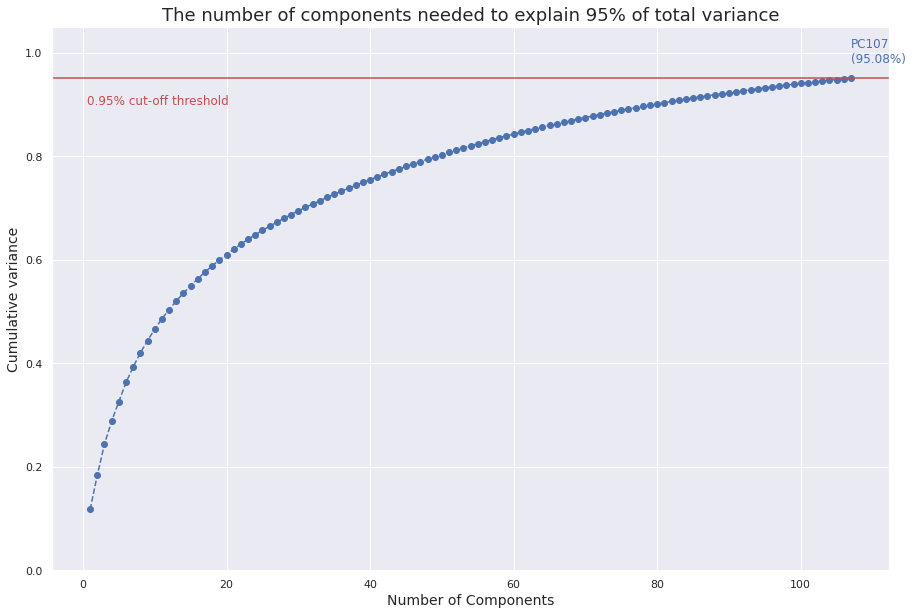

Initial number of dimension : 337
Final number of dimension : 107


,Explained variance (%),Cumulative sum
PC1,11.76,11.76
PC2,6.62,18.38
PC3,6.01,24.38
PC4,4.43,28.81
PC5,3.76,32.58
...,...,...
PC103,0.15,94.50
PC104,0.15,94.65
PC105,0.15,94.80
PC106,0.14,94.94


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,PC1,PC2,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,-12.372109,-2.043059,...,-0.175542,-1.117862,-0.246707,0.541225,-0.094437,-0.517716,0.140650,-0.666382,0.457229,0.176969
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-6.619444,-1.036887,...,0.485190,0.597150,1.241697,0.497231,-0.684211,0.192820,-0.485620,0.756156,0.442944,-1.013915
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-6.178319,-6.451937,...,0.453321,-0.837813,-0.379370,1.985620,-1.096292,0.055398,0.439213,-1.392013,-0.133204,0.737996
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-9.124357,-6.556480,...,-1.460581,0.230718,0.312560,-0.167526,0.538780,-0.001373,0.939034,0.899263,0.115939,1.338516
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-4.229493,-10.779293,...,0.768504,1.107253,0.177067,-0.892490,0.924901,1.381740,-1.695770,-0.003965,0.193232,-0.073973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,1.803461,1.922454,...,0.055900,-0.425274,0.077887,-0.682487,0.388709,0.211595,0.395068,0.297772,1.420893,0.719155
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,1.824354,10.298834,...,-0.239978,-0.197640,-0.651634,0.183729,0.999290,1.410341,0.908997,0.016685,-1.130439,0.707150
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,8.827928,2.809567,...,0.002095,0.506374,-0.122140,-0.061594,-0.415514,0.128766,0.336675,0.072300,-1.104103,0.741576
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,3.359106,6.859640,...,0.366038,0.735823,0.019698,-0.400398,-0.679777,-0.000146,0.654175,-0.476249,-1.097872,-0.359480


In [176]:
X_subset, explained_variance = perform_PCA(X, part_explained_variance=0.95, concat_metadata=True, metadata=metadata)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(explained_variance)
display(X_subset)

#### We can see that we can keep 95% of the initial explained variance by hugely reducing the dimensionality (number of columns in the peak table)

#### Still we have to keep a quite large amount of components to keep the initial variance

#### Below we plot the two principal components, we can see that the two groups are not so clearly separated

In [76]:
cb.plot.pca(X, pcx=1, pcy=2, group_label=X_subset['Groups'])

Loading BokehJS ...

In [77]:
cb.plot.pca(X, pcx=1, pcy=2, group_label=X_subset['TypTumo'])

Loading BokehJS ...

### Save peak table with PCA components

In [177]:
filename = 'peakTable-PCA_95percent.csv'
X_subset.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-PCA_95percent.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


# 2 - Univariate feature selection with ANOVA F-value ([link](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection))

## 3 ways to perform the feature selection :
- ### keep a specific number of features $\hspace{2cm} \rightarrow$ <code>select_best_features(X, y, k=*nb_of_features*)</code>
- ### keep all features with ANOVA pvalue $\lt \alpha \hspace{0.39cm} \rightarrow$ <code>select_best_features(X, y, alpha=*pvalue_threshold*)</code>
- ### keep a specific percentile of features $\hspace{1.45cm} \rightarrow$ <code>select_percentile_features(X, y, percentile=*chosen_percentile*)</code>

In [80]:
def select_best_features(X, y, k=None, alpha=None, concat_metadata=False, metadata=None):
    
    if k==None:
        k = X.shape[1]
    if alpha==None:
        alpha = 2
    
    # Assertions
    if concat_metadata:
        # assert metadata != None
        assert not isinstance(metadata, type(None)),\
            'If <merge_metadata> is set to True, <metadata> has to be provided'
    
    # Compute the ANOVA F-value
    f_statistic, p_values = f_classif(X, y)

    # Create dataframe with f_score and p_value for each feature
    df_f_classif = pd.DataFrame(list(zip(X.columns.values, f_statistic, p_values)), columns=['features', 'f_scores', 'p_values'])\
    .sort_values(by ='f_scores', ascending=False)
    df_f_classif = df_f_classif.round({'f_scores': 3, 'p_values': 4})
    
    # Subset df_f_classif based on k and p_value
    df_f_classif = df_f_classif.iloc[:k,:]
    df_f_classif = df_f_classif[df_f_classif['p_values'] < alpha]
    
    # Subset X with selected features
    subset = X[df_f_classif['features'].values]
    
    # Concat metadata if set to True
    if concat_metadata:
        subset = pd.concat([metadata, subset], axis=1)
    
    return subset, df_f_classif

### Select only k-best features

In this case, we choose a specific number of features that we want to keep.
- Advantage : you know exactly how many features you will have after the dimensionality reduction.
- Disadvantage : you will maybe not keep enough features, hugely reducing the variance of the original data

#### If we don't pass k as argument, k is set to the number of columns in the peak table, the returned *X_subset* is the original *X*

In [81]:
y = peakTable['Groups']

In [82]:
X_subset, feature_scores = select_best_features(X, y)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(X_subset)

Initial number of dimension : 337
Final number of dimension : 337


,features,f_scores,p_values
283,variable_2013,46.184,0.0000
249,variable_1667,41.357,0.0000
250,variable_1674,32.775,0.0000
240,variable_1587,24.734,0.0000
96,variable_455,22.361,0.0000
...,...,...,...
48,variable_180,0.000,0.9860
69,variable_267,0.000,0.9928
174,variable_1025,0.000,0.9929
267,variable_1835,0.000,0.9962


,variable_2013,variable_1667,variable_1674,variable_1587,variable_455,variable_2141,variable_2196,variable_1762,variable_2081,variable_1681,...,variable_1391,variable_1162,variable_835,variable_482,variable_1129,variable_180,variable_267,variable_1025,variable_1835,variable_1484
0,1.052822,-0.119614,0.470289,-0.105022,0.120811,0.517018,-0.154074,0.718245,-0.789250,0.142306,...,1.423548,-0.572406,-8.782739,-3.496646,1.627720,1.664762,0.859457,0.309994,-1.394773,0.345663
1,0.278571,1.039616,0.192593,0.343685,-1.506445,2.549902,0.420367,0.467474,-1.084174,1.092032,...,2.015624,0.097464,-0.514912,-0.495872,1.603505,1.956497,0.172961,-0.218829,-0.562494,0.470700
2,0.833714,-1.429900,-1.452497,-0.764335,-0.593254,1.257989,0.308360,-0.748746,-0.791615,-1.125573,...,-0.102299,-0.301691,0.323936,0.627471,1.786565,2.230971,-0.516667,0.067311,0.385262,-0.596402
3,0.797869,-0.555472,0.273236,0.622027,-0.733997,0.509014,0.935708,-0.174903,-0.448236,0.584793,...,0.385935,-0.339999,-2.487528,-0.524746,1.705713,2.198599,0.218060,-0.232605,-0.232321,-0.966903
4,-1.572033,-1.958551,-1.533803,-0.566212,1.047938,-0.557725,0.160443,-0.693893,1.376066,-1.086316,...,-1.336573,-0.998327,-0.036109,0.632379,1.825918,0.755105,-0.319723,-0.741727,0.323690,-0.079609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.172354,1.194387,1.174467,0.386330,-1.280869,-0.927543,-2.462094,1.564103,0.426337,0.835646,...,-0.402138,1.193240,0.328222,-0.439363,-1.882421,-0.556257,-0.512415,0.515461,-0.075306,0.280586
182,-0.629659,-0.574183,-0.257193,-0.824235,1.271683,-1.346684,-0.727458,-0.278302,0.929723,-0.618026,...,0.567905,0.595306,-1.082348,0.534875,-1.714992,-1.028626,-0.407709,0.162279,-0.386401,0.837586
183,0.061703,0.021312,0.167951,-0.002214,1.515869,0.310907,1.084502,0.516434,-0.631435,-0.465828,...,0.442841,0.855324,0.251215,0.359950,-1.578884,-0.955430,0.440337,0.796519,-0.168408,1.061337
184,-0.711905,-0.341199,-0.691938,-0.239513,-0.281210,-1.053534,0.254889,-0.306450,1.107298,-0.720774,...,-0.167412,-0.739432,0.255290,-0.410041,-1.469144,-1.294134,0.600232,0.705778,-0.352792,1.003715


### Below we fix the number of features to keep to 20 (arbitrary value)

In [83]:
X_subset, feature_scores = select_best_features(X, y, k=20, concat_metadata=True, metadata=metadata)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(X_subset)

Initial number of dimension : 337
Final number of dimension : 20


,features,f_scores,p_values
283,variable_2013,46.184,0.0000
249,variable_1667,41.357,0.0000
250,variable_1674,32.775,0.0000
240,variable_1587,24.734,0.0000
96,variable_455,22.361,0.0000
297,variable_2141,20.026,0.0000
314,variable_2196,17.750,0.0000
260,variable_1762,17.283,0.0000
291,variable_2081,17.043,0.0001
251,variable_1681,16.818,0.0001


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_2013,variable_1667,...,variable_1800,variable_2175,variable_2166,variable_1870,variable_706,variable_2095,variable_1582,variable_263,variable_2167,variable_529
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,1.052822,-0.119614,...,1.233265,-1.264635,-0.157879,1.429595,0.064962,0.234980,-0.054988,-1.018855,-1.874528,1.490495
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,0.278571,1.039616,...,1.543585,0.099599,0.461630,1.146518,-0.612196,1.541190,0.353042,0.803527,-0.405263,1.371754
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,0.833714,-1.429900,...,0.379944,-0.290180,1.198347,-0.518906,-0.122558,1.413182,-1.579523,1.026956,-0.760444,-0.275113
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,0.797869,-0.555472,...,1.846130,-0.949558,-1.214669,0.205820,-0.884051,0.798755,0.132005,0.512894,-0.762422,0.689168
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-1.572033,-1.958551,...,0.747026,-0.440455,2.168275,-0.193212,-0.029372,0.010936,-0.864711,-2.524734,0.605600,2.084331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,0.172354,1.194387,...,-0.866168,-0.747168,0.791331,0.868139,-1.108494,-0.311805,-0.152348,0.453878,-0.363123,1.189269
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-0.629659,-0.574183,...,-1.042159,-1.069228,0.481913,-0.983988,0.316659,-1.238919,-0.717407,0.173125,0.279654,-0.015963
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,0.061703,0.021312,...,-0.859383,0.217331,-0.093000,0.293172,-1.448777,0.710022,0.215622,0.113700,0.560893,-0.279103
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.711905,-0.341199,...,-0.714894,0.094413,0.473248,-0.777531,-0.372423,-0.110575,-1.204663,0.502241,0.621438,-0.657233


In [84]:
k_subset = feature_scores.shape[0]
filename = f'peakTable-kBest_{k_subset}.csv'
X_subset.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-kBest_20.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


### Select all features with ANOVA pvalue < $\alpha$

In this case, we keep all the features with a p-value greater than a specific $\alpha$.
- Advantage : you keep most of the important features, reducing the risk to remove relevant ones.
- Disadvantage : you don't know exactly how many features you will have after the dimensionality reduction. 

In [85]:
X_subset, feature_scores = select_best_features(X, y, alpha=0.05, concat_metadata=True, metadata=metadata)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(X_subset)

Initial number of dimension : 337
Final number of dimension : 61


,features,f_scores,p_values
283,variable_2013,46.184,0.0000
249,variable_1667,41.357,0.0000
250,variable_1674,32.775,0.0000
240,variable_1587,24.734,0.0000
96,variable_455,22.361,0.0000
...,...,...,...
245,variable_1640,4.311,0.0393
84,variable_375,4.166,0.0427
138,variable_766,4.161,0.0428
210,variable_1309,3.983,0.0474


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_2013,variable_1667,...,variable_2101,variable_28,variable_335,variable_10,variable_291,variable_1640,variable_375,variable_766,variable_1309,variable_1045
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,1.052822,-0.119614,...,-0.788669,-0.328717,-0.185338,0.292690,-0.581835,-0.744024,0.462155,0.390023,0.497181,-1.413445
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,0.278571,1.039616,...,-1.148507,0.708362,0.014319,-0.303024,-0.794323,-2.142292,-0.895578,-0.296164,1.077789,-1.132318
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,0.833714,-1.429900,...,-0.991557,-0.125575,-0.013677,-0.951130,-0.985590,-0.892396,-0.006299,1.159141,-1.310987,-1.111290
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,0.797869,-0.555472,...,-1.655048,1.555650,-0.032395,1.013887,0.148903,-1.398748,-0.094420,0.781941,-0.175779,-2.231444
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-1.572033,-1.958551,...,-0.053753,-0.965823,0.023192,-0.288708,-0.816637,1.318288,1.231592,0.453678,0.552040,-0.265451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,0.172354,1.194387,...,1.303996,1.086177,1.543091,-0.497824,-0.645610,-0.822342,-0.158959,-0.039306,0.169712,0.618687
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-0.629659,-0.574183,...,0.533509,-0.711123,-0.134994,-1.122356,-0.279594,-0.640144,0.267372,0.026023,0.520890,-0.982146
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,0.061703,0.021312,...,0.072811,-0.696082,-0.631811,-0.957686,-1.593399,-0.608761,1.834730,-0.131172,-0.079227,0.631821
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.711905,-0.341199,...,1.067010,-0.066340,1.372061,-1.491989,-0.734200,-1.059683,-0.555558,-1.122232,-0.990108,0.816945


In [86]:
k_subset = feature_scores.shape[0]
filename = f'peakTable-kBest_{k_subset}.csv'
X_subset.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-kBest_61.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


### Plot p-value and ANOVA F-value for each selected feature

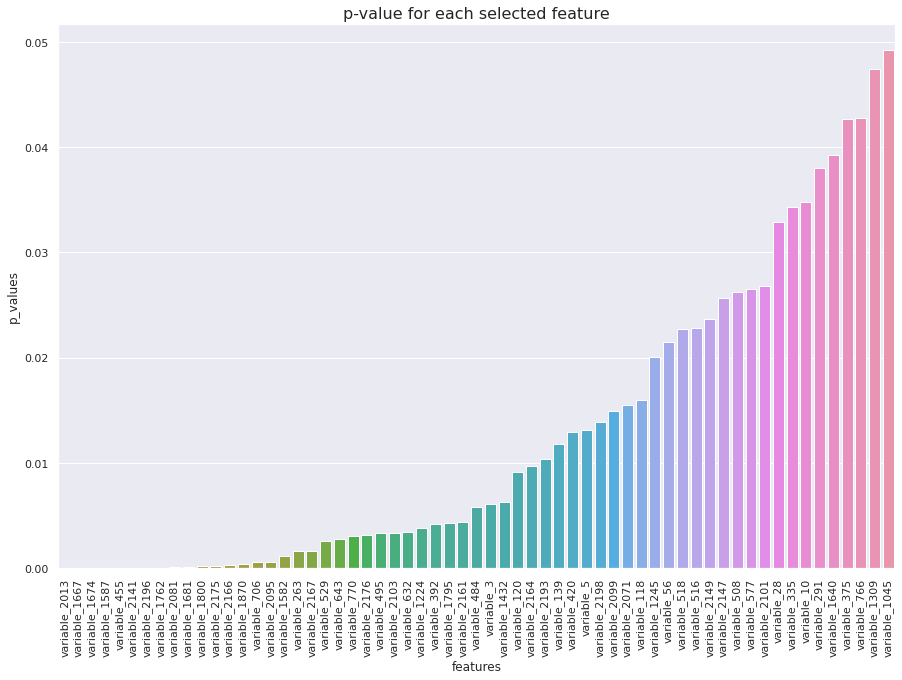

In [87]:
ax = sns.barplot(data=feature_scores, x='features', y='p_values');
plt.xticks(rotation=90)
ax.set_title('p-value for each selected feature', fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

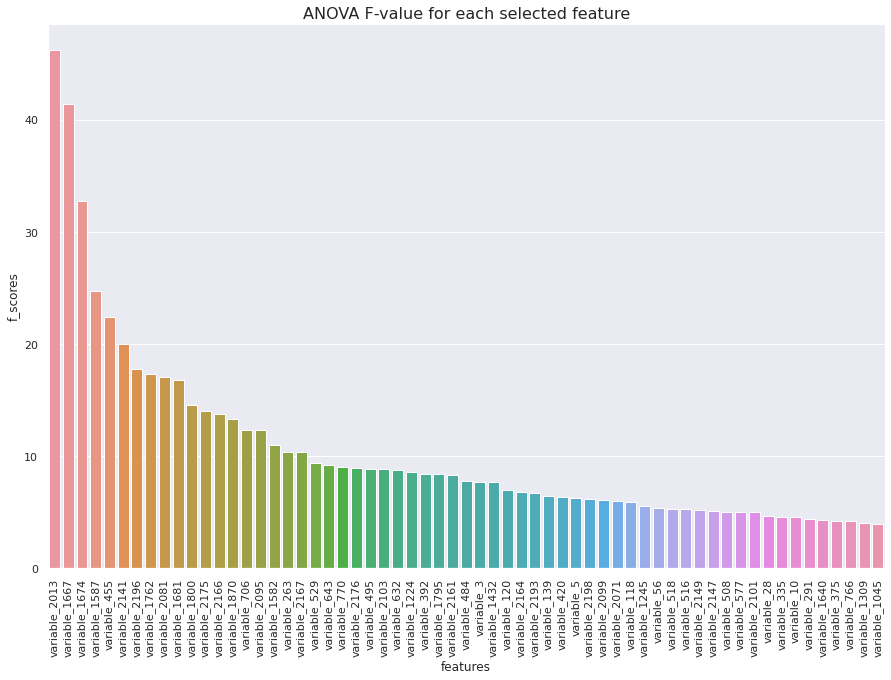

In [88]:
ax = sns.barplot(data=feature_scores, x='features', y='f_scores');
plt.xticks(rotation=90)
ax.set_title('ANOVA F-value for each selected feature', fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

## b - Select features according to a percentile of the highest scores

In this case, we choose a specific percent of features that we want to keep.
- Advantage : you know exactly how many features you will have after the dimensionality reduction.
- Disadvantage : you will maybe not keep enough features, hugely reducing the variance of the original data

#### If we don't pass k as argument, k is set to the number of columns in the peak table, the returned *X_subset* is the original *X*

In [89]:
def select_percentile_features(X, y, percentile=100, concat_metadata=False, metadata=None):

    # Compute the ANOVA F-value
    f_statistic, p_values = f_classif(X, y)

    # Create dataframe with f_score and p_value for each feature
    df_f_classif = pd.DataFrame(list(zip(X.columns.values, f_statistic, p_values)), columns=['features', 'f_scores', 'p_values'])\
    .sort_values(by ='f_scores', ascending=False)
    df_f_classif = df_f_classif.round({'f_scores': 3, 'p_values': 4})
    
    # Subset X with selected features
    selector = SelectPercentile(f_classif, percentile=percentile)
    X_new = selector.fit_transform(X, y)
    columns = X.columns.values
    subset_columns = selector.get_support()
    kept_features = columns[subset_columns]
    subset = X[kept_features]
    
    # Subset df_f_classif based on ketp features
    df_f_classif = df_f_classif[df_f_classif['features'].isin(kept_features)]
    
    # Concat metadata if set to True
    if concat_metadata:
        subset = pd.concat([metadata, subset], axis=1)
    
    return subset, df_f_classif

In [90]:
X_subset, feature_scores = select_percentile_features(X, y, percentile=10, concat_metadata=True, metadata=metadata)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(X_subset)

Initial number of dimension : 337
Final number of dimension : 34


,features,f_scores,p_values
283,variable_2013,46.184,0.0000
249,variable_1667,41.357,0.0000
250,variable_1674,32.775,0.0000
240,variable_1587,24.734,0.0000
96,variable_455,22.361,0.0000
297,variable_2141,20.026,0.0000
314,variable_2196,17.750,0.0000
260,variable_1762,17.283,0.0000
291,variable_2081,17.043,0.0001
251,variable_1681,16.818,0.0001


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,variable_3,variable_120,...,variable_2081,variable_2095,variable_2103,variable_2141,variable_2161,variable_2166,variable_2167,variable_2175,variable_2176,variable_2196
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,0.343154,0.127026,...,-0.789250,0.234980,0.116475,0.517018,-0.462775,-0.157879,-1.874528,-1.264635,-1.381573,-0.154074
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,0.514293,-0.049328,...,-1.084174,1.541190,-2.408967,2.549902,1.087210,0.461630,-0.405263,0.099599,0.513245,0.420367
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-0.966684,0.126258,...,-0.791615,1.413182,-1.062026,1.257989,1.712662,1.198347,-0.760444,-0.290180,-0.238342,0.308360
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-0.499471,-1.156059,...,-0.448236,0.798755,-0.591333,0.509014,-1.274077,-1.214669,-0.762422,-0.949558,-0.654505,0.935708
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,0.789406,1.593500,...,1.376066,0.010936,1.003222,-0.557725,0.387194,2.168275,0.605600,-0.440455,-0.183140,0.160443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,1.198158,-0.835358,...,0.426337,-0.311805,0.926487,-0.927543,0.242094,0.791331,-0.363123,-0.747168,-0.174288,-2.462094
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-0.232292,0.160077,...,0.929723,-1.238919,0.497878,-1.346684,0.247322,0.481913,0.279654,-1.069228,-0.034998,-0.727458
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,0.002991,1.735187,...,-0.631435,0.710022,0.026396,0.310907,0.194301,-0.093000,0.560893,0.217331,0.362668,1.084502
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.984124,-0.186494,...,1.107298,-0.110575,0.756917,-1.053534,0.167278,0.473248,0.621438,0.094413,-0.028288,0.254889


In [91]:
k_subset = feature_scores.shape[0]
filename = f'peakTable-kBest_{k_subset}.csv'
X_subset.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-kBest_34.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


# t-SNE

## /!\ CAUTION /!\ : We have to be careful with t-SNE and UMAP algorithms with high dimensionality data : we can first reduce data with PCA to a reasonable number of features then use t-SNE or UMAP to finally reduce to 2 or 3 dimensions

- https://towardsdatascience.com/t-sne-python-example-1ded9953f26

## Input data for t-SNE should be normalised, to treate *dimensions with equal importance*  :
- https://stats.stackexchange.com/questions/164917/should-data-be-centeredscaled-before-applying-t-sne
- https://jlmelville.github.io/smallvis/norm.html#conclusions

In [92]:
from sklearn.manifold import TSNE

In [93]:
targets = ['Groups', 'TypTumo']
targets

['Groups', 'TypTumo']

In [128]:
def perform_tSNE(X, metadata, n_components=2, targets_plot=[], concat_metadata=False):
    
    # Apply StandardScaler() if not already done
    if (X.mean().mean() < 0.01) & (0.99 < X.std().mean() < 1.01):
        X_std = X
    else:
        X_std = StandardScaler().fit_transform(X)
        
        
    # Assertion
    assert (n_components==2 or n_components==3),\
        '<n_components> has to be either 2 or 3'
        
    
    # Perform t-SNE
    start_time = time.time()
    X_tSNE = TSNE(n_components=n_components, learning_rate='auto', init='random', random_state=0).fit_transform(X_std)
    print(f'Time to compute t-SNE (input dataframe of shape {X_std.shape}) : {time.time() - start_time :.2f} seconds\n')
    
    # Prepare column names
    col_names = ['tSNE' + str(i+1) for i in range(n_components)]
    index = X.index.values
    
    
    # Prepare df dataframe to return
    # Concat metadata if set to True
    if concat_metadata:
        df_tSNE = pd.concat([metadata, pd.DataFrame(X_tSNE, columns=col_names, index=index)], axis=1)
    else:
        df_tSNE = pd.DataFrame(X_tSNE, columns=col_names, index=index)

    
    # Plot t-SNE dimensions
    if n_components == 2:
        
        print(100 * '-')
        if targets_plot==[]:
            plt.figure(figsize=(12,8))
            sns.scatterplot(x=0, y=1, data=pd.DataFrame(X_tSNE),
                            s=50, legend='full', palette='deep');
            plt.xlabel('t-SNE (1st dimension)', fontsize=14)
            plt.ylabel('t-SNE (2nd dimension)', fontsize=14)
            plt.title(f't-SNE first two components', fontsize=18)
            plt.show()
            print(100 * '-')
        else:
            for target in targets_plot:

                plt.figure(figsize=(12,8))
                sns.scatterplot(x=0, y=1, data=pd.DataFrame(X_tSNE), hue=metadata[target],
                                s=50, legend='full', palette='deep');
                plt.xlabel('t-SNE (1st dimension)', fontsize=14)
                plt.ylabel('t-SNE (2nd dimension)', fontsize=14)
                plt.title(f't-SNE first two components, colored by {target}', fontsize=18)
                plt.show()
                print(100 * '-')
            
    elif n_components == 3:
        
        print(100 * '-', '\n')
        if targets_plot==[]:
            fig = plt.figure(figsize=(15,10))
            ax = fig.add_subplot(111, projection = '3d')

            scatter = ax.scatter(
                xs=X_tSNE[:,0], 
                ys=X_tSNE[:,1], 
                zs=X_tSNE[:,2],
                cmap='rainbow',
                s=50,
                alpha=1
            )
            ax.set_xlabel('t-SNE (1st dimension)')
            ax.set_ylabel('t-SNE (2nd dimension)')
            ax.set_zlabel('t-SNE (3rd dimension)')
            ax.set_title(f't-SNE first 3 components', fontsize=18)
            
            plt.show()
            
        else :
            for target in targets_plot:

                fig = plt.figure(figsize=(15,10))
                ax = fig.add_subplot(111, projection = '3d')

                le = LabelEncoder()
                le.fit(metadata[target])
                encoded_labels = le.transform(metadata[target])
                le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
                print(f'Corresponding labels for each class in legend : {le_name_mapping}\n')

                scatter = ax.scatter(
                    xs=X_tSNE[:,0], 
                    ys=X_tSNE[:,1], 
                    zs=X_tSNE[:,2],
                    c=encoded_labels,
                    cmap='rainbow',
                    s=50,
                    alpha=1
                )
                ax.set_xlabel('t-SNE (1st dimension)')
                ax.set_ylabel('t-SNE (2nd dimension)')
                ax.set_zlabel('t-SNE (3rd dimension)')
                ax.set_title(f't-SNE first 3 components, colored by {target}', fontsize=18)

                legend1 = ax.legend(*scatter.legend_elements(), loc='upper right', title=target)
                ax.add_artist(legend1)

                plt.show()

            print(100 * '-', '\n')
            
    return df_tSNE

## t-SNE on raw data

## 2 dimensions

Time to compute t-SNE (input dataframe of shape (186, 337)) : 0.37 seconds

----------------------------------------------------------------------------------------------------


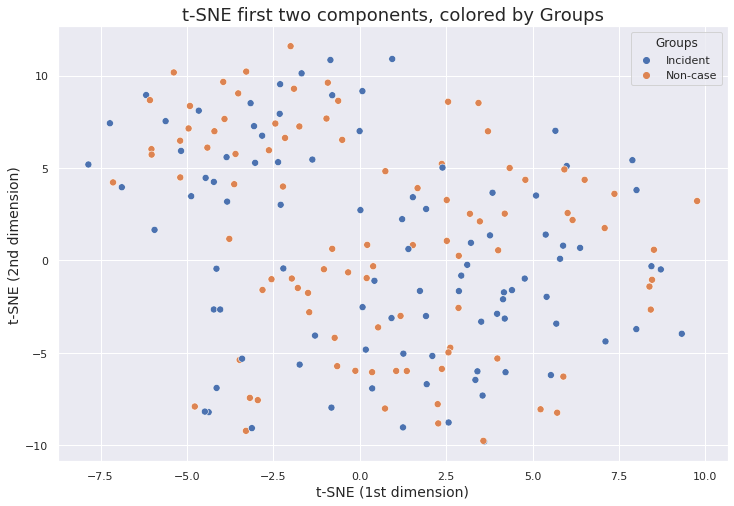

----------------------------------------------------------------------------------------------------


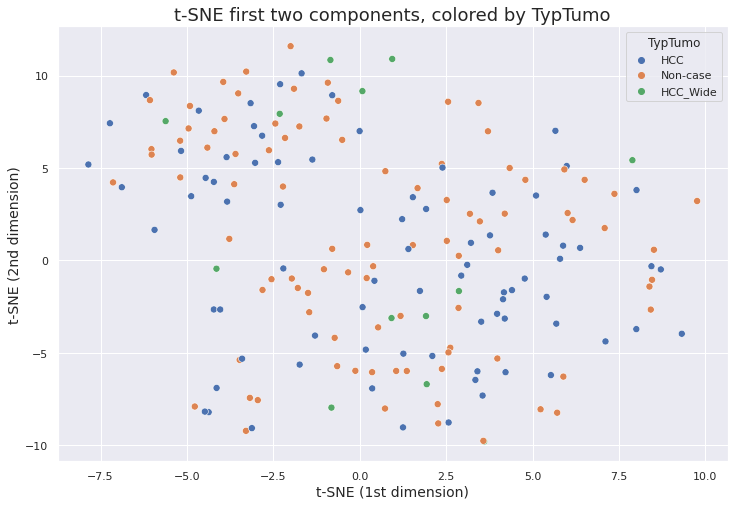

----------------------------------------------------------------------------------------------------


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,tSNE1,tSNE2
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,-1.372047,5.460390
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-5.380871,10.177113
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-4.657800,8.107827
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-4.911975,8.362885
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,0.076166,9.166436
...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,5.888816,-6.289124
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,3.403260,-6.002841
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,1.053000,-5.982510
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,5.528458,-6.207177


In [138]:
n_components = 2
peakTable_tSNE = perform_tSNE(X, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
peakTable_tSNE

In [139]:
filename = f'peakTable-tSNE_{n_components}comp.csv'
peakTable_tSNE.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-tSNE_2comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


## 3 dimensions

Time to compute t-SNE (input dataframe of shape (186, 337)) : 0.72 seconds

---------------------------------------------------------------------------------------------------- 

Corresponding labels for each class in legend : {'Incident': 0, 'Non-case': 1}



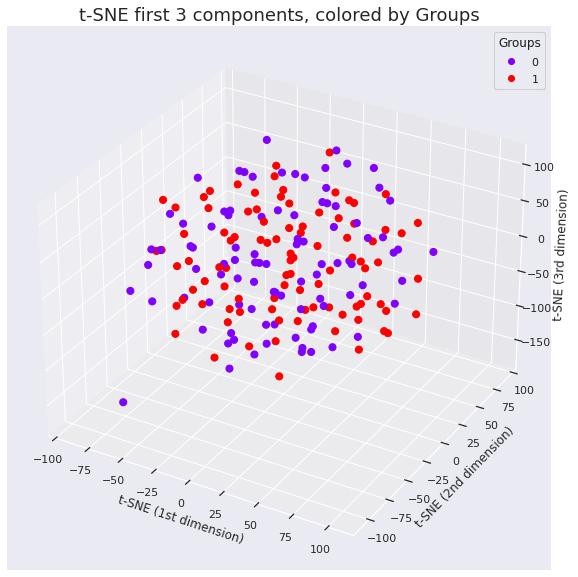

Corresponding labels for each class in legend : {'HCC': 0, 'HCC_Wide': 1, 'Non-case': 2}



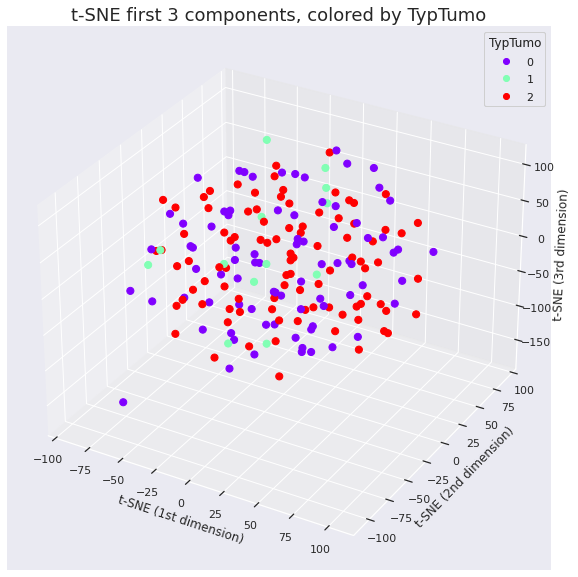

---------------------------------------------------------------------------------------------------- 



,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,tSNE1,tSNE2,tSNE3
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,-59.849751,52.155758,46.061970
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-10.512432,6.745822,104.207024
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,-50.456680,30.002071,71.612961
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-52.115822,30.558516,51.275833
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,13.111001,30.526632,106.895699
...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,-58.641850,65.913498,-18.737181
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-6.966667,-24.147411,15.126659
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,-6.583768,24.171803,-22.720762
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-70.848099,49.463345,-18.831356


In [140]:
n_components = 3
peakTable_tSNE = perform_tSNE(X, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
peakTable_tSNE

In [141]:
filename = f'peakTable-tSNE_{n_components}comp.csv'
peakTable_tSNE.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-tSNE_3comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


## PCA then t-SNE

#################################################################################################### 



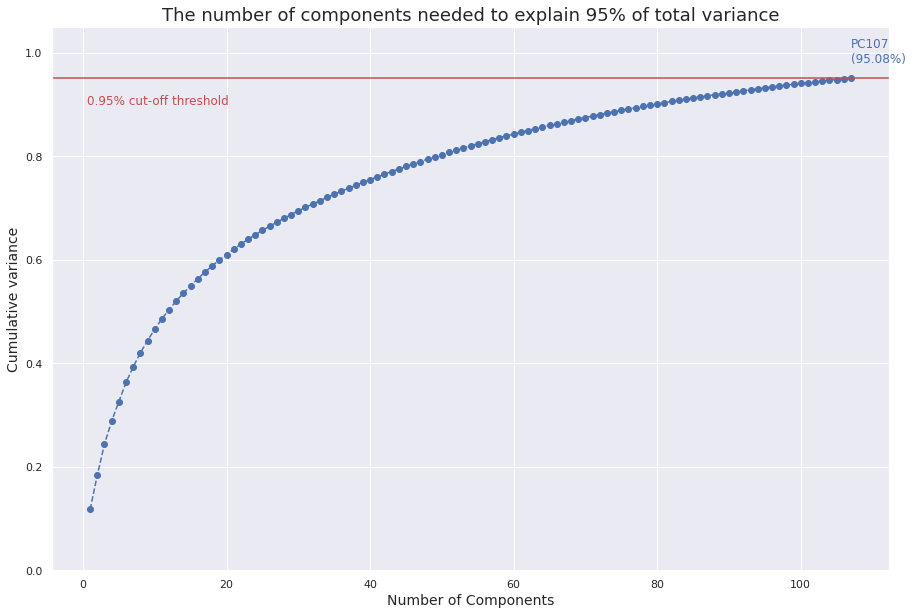

Initial number of dimension : 337
Final number of dimension : 107


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
0,-12.372109,-2.043059,-3.261698,0.430363,4.269989,0.939417,0.664265,-0.267621,1.883309,0.512214,...,-0.175542,-1.117862,-0.246707,0.541225,-0.094437,-0.517716,0.140650,-0.666382,0.457229,0.176969
1,-6.619444,-1.036887,-4.825797,-7.892051,4.473196,7.474913,2.972063,-0.679043,-0.398766,3.957368,...,0.485190,0.597150,1.241697,0.497231,-0.684211,0.192820,-0.485620,0.756156,0.442944,-1.013915
2,-6.178319,-6.451937,0.216316,-0.336971,3.268509,-0.351904,3.361514,1.504637,1.773554,-0.439789,...,0.453321,-0.837813,-0.379370,1.985620,-1.096292,0.055398,0.439213,-1.392013,-0.133204,0.737996
3,-9.124357,-6.556480,0.056527,-0.308370,-0.204270,4.008856,-0.137532,1.881414,-2.466897,1.671776,...,-1.460581,0.230718,0.312560,-0.167526,0.538780,-0.001373,0.939034,0.899263,0.115939,1.338516
4,-4.229493,-10.779293,4.640299,-4.065250,5.467090,-7.372899,1.694997,-3.111410,1.941444,1.120718,...,0.768504,1.107253,0.177067,-0.892490,0.924901,1.381740,-1.695770,-0.003965,0.193232,-0.073973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1.803461,1.922454,-1.699863,-7.086195,-0.992577,-1.464068,-2.944835,0.421351,-3.520668,2.028967,...,0.055900,-0.425274,0.077887,-0.682487,0.388709,0.211595,0.395068,0.297772,1.420893,0.719155
182,1.824354,10.298834,-3.895671,-1.744359,1.796563,-5.284780,-1.436543,1.535927,3.448473,-0.295000,...,-0.239978,-0.197640,-0.651634,0.183729,0.999290,1.410341,0.908997,0.016685,-1.130439,0.707150
183,8.827928,2.809567,-2.420940,-4.340115,0.457351,-1.307642,-0.602169,-3.289612,2.381454,-1.449033,...,0.002095,0.506374,-0.122140,-0.061594,-0.415514,0.128766,0.336675,0.072300,-1.104103,0.741576
184,3.359106,6.859640,-4.879737,-1.896727,-0.556661,-1.860155,1.866356,0.884209,-1.428245,5.293333,...,0.366038,0.735823,0.019698,-0.400398,-0.679777,-0.000146,0.654175,-0.476249,-1.097872,-0.359480



 #################################################################################################### 

Time to compute t-SNE (input dataframe of shape (186, 107)) : 0.78 seconds

---------------------------------------------------------------------------------------------------- 

Corresponding labels for each class in legend : {'Incident': 0, 'Non-case': 1}



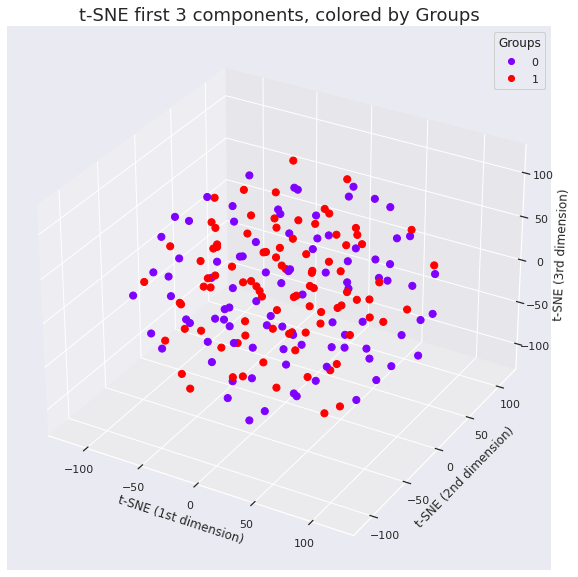

Corresponding labels for each class in legend : {'HCC': 0, 'HCC_Wide': 1, 'Non-case': 2}



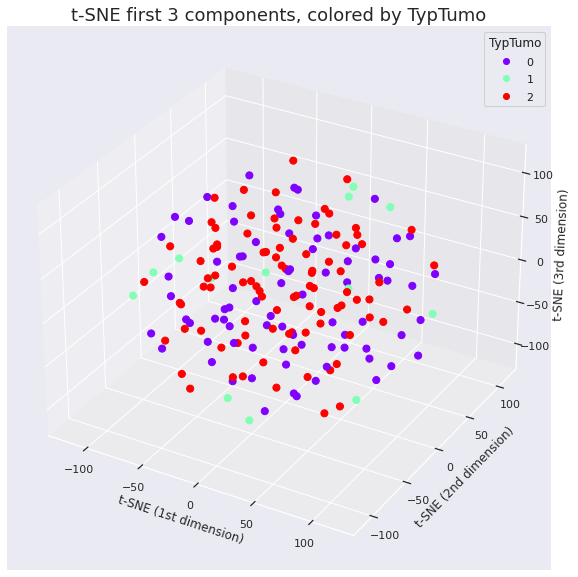

---------------------------------------------------------------------------------------------------- 



,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,tSNE1,tSNE2,tSNE3
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,-47.770306,-88.040070,59.272099
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-79.892548,25.409912,62.975338
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,57.734390,-5.433440,59.722309
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,8.613297,-32.720695,-16.732248
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-94.453407,41.745876,-46.891159
...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,-54.177532,-13.647569,62.535851
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-21.443333,-8.146850,54.563503
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,25.753040,0.386738,86.282364
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-45.667465,-101.944901,-11.521754


In [150]:
print(100 * '#', '\n')

X_PCA, explained_variance = perform_PCA(X, part_explained_variance=0.95)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(X_PCA)

print('\n', 100 * '#', '\n')

n_components = 3
peakTable_PCA_tSNE = perform_tSNE(X_PCA, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
display(peakTable_PCA_tSNE)

In [151]:
filename = f'peakTable-PCA_95percent-tSNE_{n_components}comp.csv'
peakTable_PCA_tSNE.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-PCA_95percent-tSNE_3comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


#################################################################################################### 



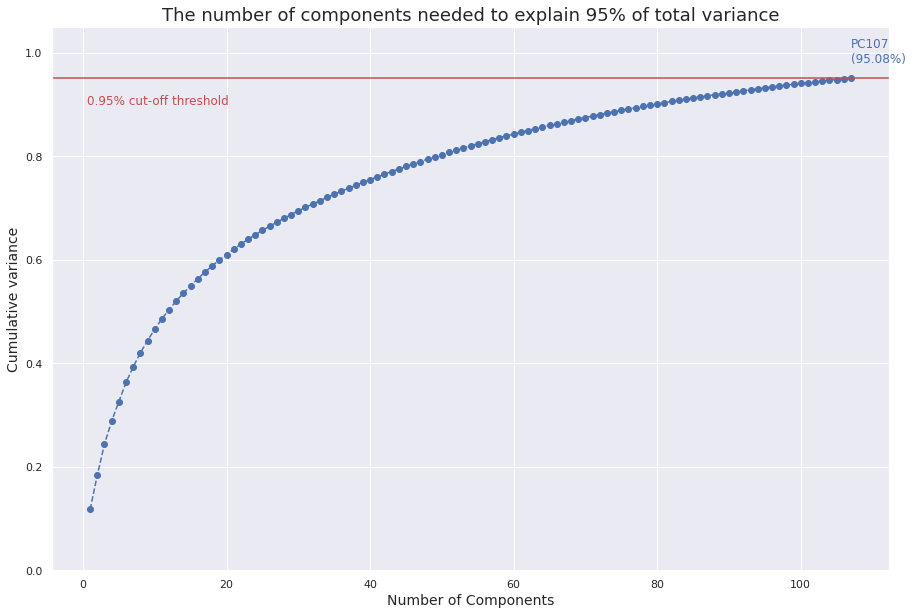

Initial number of dimension : 337
Final number of dimension : 107


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
0,-12.372109,-2.043059,-3.261698,0.430363,4.269989,0.939417,0.664265,-0.267621,1.883309,0.512214,...,-0.175542,-1.117862,-0.246707,0.541225,-0.094437,-0.517716,0.140650,-0.666382,0.457229,0.176969
1,-6.619444,-1.036887,-4.825797,-7.892051,4.473196,7.474913,2.972063,-0.679043,-0.398766,3.957368,...,0.485190,0.597150,1.241697,0.497231,-0.684211,0.192820,-0.485620,0.756156,0.442944,-1.013915
2,-6.178319,-6.451937,0.216316,-0.336971,3.268509,-0.351904,3.361514,1.504637,1.773554,-0.439789,...,0.453321,-0.837813,-0.379370,1.985620,-1.096292,0.055398,0.439213,-1.392013,-0.133204,0.737996
3,-9.124357,-6.556480,0.056527,-0.308370,-0.204270,4.008856,-0.137532,1.881414,-2.466897,1.671776,...,-1.460581,0.230718,0.312560,-0.167526,0.538780,-0.001373,0.939034,0.899263,0.115939,1.338516
4,-4.229493,-10.779293,4.640299,-4.065250,5.467090,-7.372899,1.694997,-3.111410,1.941444,1.120718,...,0.768504,1.107253,0.177067,-0.892490,0.924901,1.381740,-1.695770,-0.003965,0.193232,-0.073973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1.803461,1.922454,-1.699863,-7.086195,-0.992577,-1.464068,-2.944835,0.421351,-3.520668,2.028967,...,0.055900,-0.425274,0.077887,-0.682487,0.388709,0.211595,0.395068,0.297772,1.420893,0.719155
182,1.824354,10.298834,-3.895671,-1.744359,1.796563,-5.284780,-1.436543,1.535927,3.448473,-0.295000,...,-0.239978,-0.197640,-0.651634,0.183729,0.999290,1.410341,0.908997,0.016685,-1.130439,0.707150
183,8.827928,2.809567,-2.420940,-4.340115,0.457351,-1.307642,-0.602169,-3.289612,2.381454,-1.449033,...,0.002095,0.506374,-0.122140,-0.061594,-0.415514,0.128766,0.336675,0.072300,-1.104103,0.741576
184,3.359106,6.859640,-4.879737,-1.896727,-0.556661,-1.860155,1.866356,0.884209,-1.428245,5.293333,...,0.366038,0.735823,0.019698,-0.400398,-0.679777,-0.000146,0.654175,-0.476249,-1.097872,-0.359480



 #################################################################################################### 

Time to compute t-SNE (input dataframe of shape (186, 107)) : 0.71 seconds

----------------------------------------------------------------------------------------------------


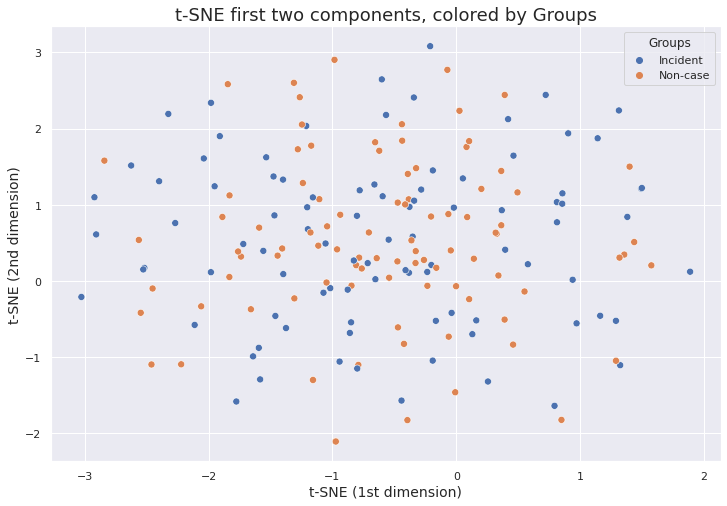

----------------------------------------------------------------------------------------------------


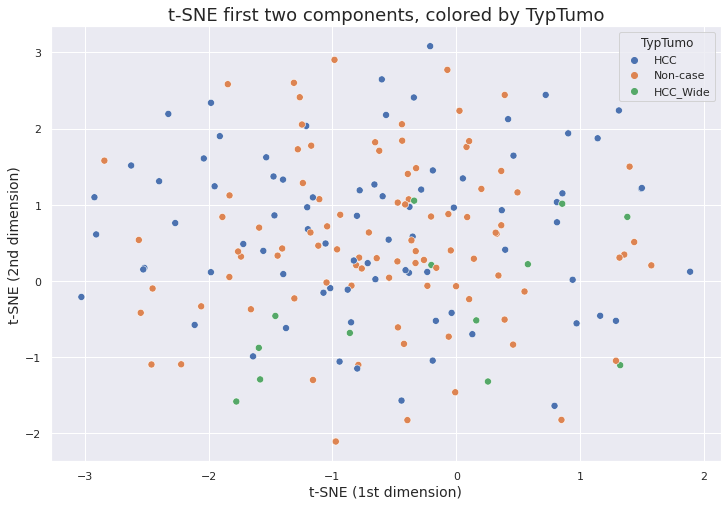

----------------------------------------------------------------------------------------------------


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,tSNE1,tSNE2
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,0.417830,2.124475
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,-2.548371,-0.418698
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,0.366884,0.928238
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,-0.324994,1.480722
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,-1.461150,-0.460158
...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,-0.791154,-1.103697
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-1.397257,0.089465
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,-0.475833,0.256047
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.800170,-1.150811


In [169]:
print(100 * '#', '\n')

X_PCA, explained_variance = perform_PCA(X, part_explained_variance=0.95)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(X_PCA)

print('\n', 100 * '#', '\n')

n_components = 2
peakTable_PCA_tSNE = perform_tSNE(X_PCA, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
display(peakTable_PCA_tSNE)

In [170]:
filename = f'peakTable-PCA_95percent-tSNE_{n_components}comp.csv'
peakTable_PCA_tSNE.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-PCA_95percent-tSNE_2comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


# UMAP

In [152]:
from umap import UMAP

In [155]:
def perform_UMAP(X, metadata, n_components=2, targets_plot=[], concat_metadata=False):
    
    # Apply StandardScaler() if not already done
    if (X.mean().mean() < 0.01) & (0.99 < X.std().mean() < 1.01):
        X_std = X
    else:
        X_std = StandardScaler().fit_transform(X)
        
        
    # Assertion
    assert (n_components==2 or n_components==3),\
        '<n_components> has to be either 2 or 3'
        
    
    # Perform UMAP
    start_time = time.time()
    X_UMAP = UMAP(n_components=n_components, init='random', random_state=0).fit_transform(X_std)
    print(f'Time to compute UMAP (input dataframe of shape {X_std.shape}) : {time.time() - start_time :.2f} seconds\n')

    
    
    # Prepare column names
    col_names = ['UMAP' + str(i+1) for i in range(n_components)]
    index = X.index.values
    
    
    # Prepare df dataframe to return
    # Concat metadata if set to True
    if concat_metadata:
        df_UMAP = pd.concat([metadata, pd.DataFrame(X_UMAP, columns=col_names, index=index)], axis=1)
    else:
        df_UMAP = pd.DataFrame(X_UMAP, columns=col_names, index=index)

    
    # Plot t-SNE dimensions
    if n_components == 2:
        
        print(100 * '-')
        if targets_plot==[]:
            plt.figure(figsize=(12,8))
            sns.scatterplot(x=0, y=1, data=pd.DataFrame(X_UMAP),
                            s=50, legend='full', palette='deep');
            plt.xlabel('UMAP (1st dimension)', fontsize=14)
            plt.ylabel('UMAP (2nd dimension)', fontsize=14)
            plt.title(f'UMAP first two components', fontsize=18)
            plt.show()
            print(100 * '-')
        else:
            for target in targets_plot:

                plt.figure(figsize=(12,8))
                sns.scatterplot(x=0, y=1, data=pd.DataFrame(X_UMAP), hue=metadata[target],
                                s=50, legend='full', palette='deep');
                plt.xlabel('UMAP (1st dimension)', fontsize=14)
                plt.ylabel('UMAP (2nd dimension)', fontsize=14)
                plt.title(f'UMAP first two components, colored by {target}', fontsize=18)
                plt.show()
                print(100 * '-')
            
    elif n_components == 3:
        
        print(100 * '-', '\n')
        if targets_plot==[]:
            fig = plt.figure(figsize=(15,10))
            ax = fig.add_subplot(111, projection = '3d')

            scatter = ax.scatter(
                xs=X_UMAP[:,0], 
                ys=X_UMAP[:,1], 
                zs=X_UMAP[:,2],
                cmap='rainbow',
                s=50,
                alpha=1
            )
            ax.set_xlabel('UMAP (1st dimension)')
            ax.set_ylabel('UMAP (2nd dimension)')
            ax.set_zlabel('UMAP (3rd dimension)')
            ax.set_title(f'UMAP first 3 components', fontsize=18)
            
            plt.show()
            
        else :
            for target in targets_plot:

                fig = plt.figure(figsize=(15,10))
                ax = fig.add_subplot(111, projection = '3d')

                le = LabelEncoder()
                le.fit(metadata[target])
                encoded_labels = le.transform(metadata[target])
                le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
                print(f'Corresponding labels for each class in legend : {le_name_mapping}\n')

                scatter = ax.scatter(
                    xs=X_UMAP[:,0], 
                    ys=X_UMAP[:,1], 
                    zs=X_UMAP[:,2],
                    c=encoded_labels,
                    cmap='rainbow',
                    s=50,
                    alpha=1
                )
                ax.set_xlabel('UMAP (1st dimension)')
                ax.set_ylabel('UMAP (2nd dimension)')
                ax.set_zlabel('UMAP (3rd dimension)')
                ax.set_title(f'UMAP first 3 components, colored by {target}', fontsize=18)

                legend1 = ax.legend(*scatter.legend_elements(), loc='upper right', title=target)
                ax.add_artist(legend1)

                plt.show()

            print(100 * '-', '\n')
            
    return df_UMAP

## UMAP on raw data

## 2 dimensions

Time to compute UMAP (input dataframe of shape (186, 337)) : 0.71 seconds

----------------------------------------------------------------------------------------------------


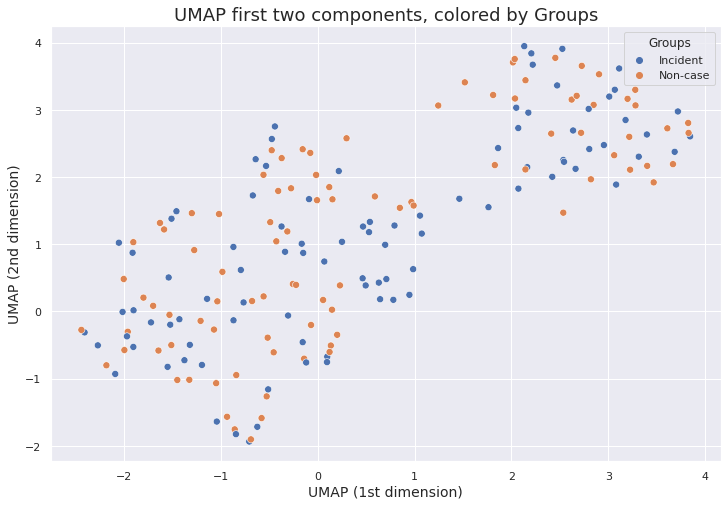

----------------------------------------------------------------------------------------------------


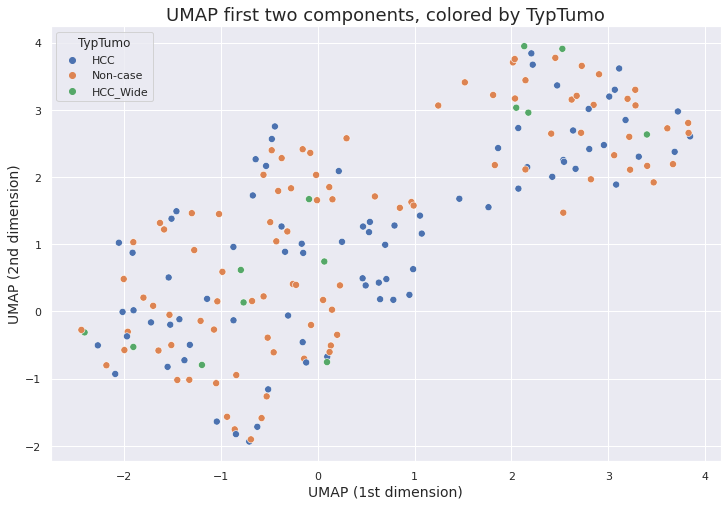

----------------------------------------------------------------------------------------------------


,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,UMAP1,UMAP2
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,3.845482,2.604651
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,3.825681,2.804530
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,3.719204,2.975631
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,3.829534,2.656100
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,2.525699,3.908016
...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,-1.211830,-0.141788
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-2.017905,-0.008276
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,-1.514205,-0.501866
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-1.525376,-0.198339


In [162]:
n_components = 2
peakTable_UMAP = perform_UMAP(X, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
peakTable_UMAP

In [163]:
filename = f'peakTable-UMAP_{n_components}comp.csv'
peakTable_UMAP.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-UMAP_2comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


## 3 dimensions

Time to compute UMAP (input dataframe of shape (186, 337)) : 0.75 seconds

---------------------------------------------------------------------------------------------------- 

Corresponding labels for each class in legend : {'Incident': 0, 'Non-case': 1}



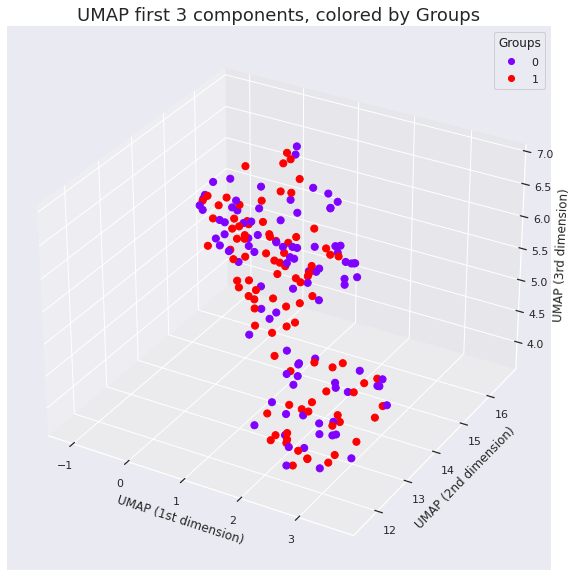

Corresponding labels for each class in legend : {'HCC': 0, 'HCC_Wide': 1, 'Non-case': 2}



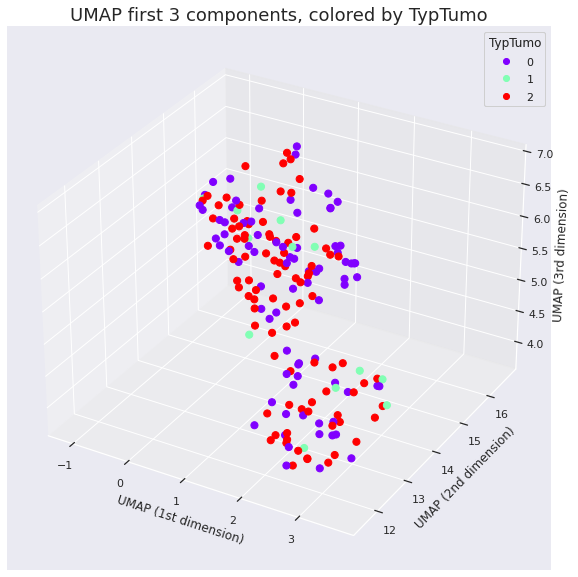

---------------------------------------------------------------------------------------------------- 



,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,UMAP1,UMAP2,UMAP3
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,2.571931,11.635099,4.042421
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,2.799978,11.584227,4.360549
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,2.909287,12.081591,3.888407
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,2.834971,11.814544,4.145711
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,3.592559,12.961088,4.663939
...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,-0.735358,15.102514,5.153733
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,-0.780439,15.029854,5.742425
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,-0.355945,15.793537,5.322152
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,-0.657033,15.229920,5.239809


In [164]:
n_components = 3
peakTable_UMAP = perform_UMAP(X, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
peakTable_UMAP

In [165]:
filename = f'peakTable-UMAP_{n_components}comp.csv'
peakTable_UMAP.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-UMAP_3comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/


## PCA then UMAP

#################################################################################################### 



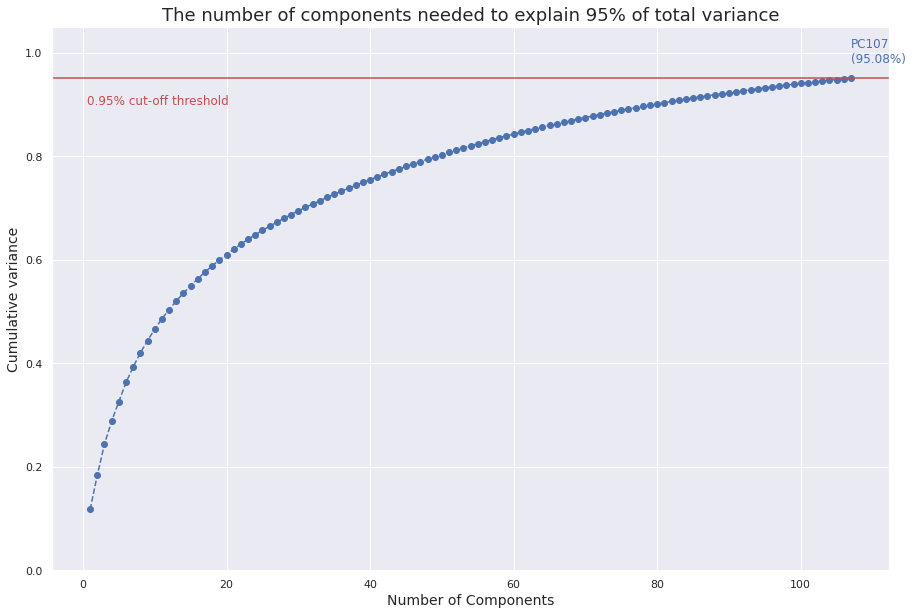

Initial number of dimension : 337
Final number of dimension : 107


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107
0,-12.372109,-2.043059,-3.261698,0.430363,4.269989,0.939417,0.664265,-0.267621,1.883309,0.512214,...,-0.175542,-1.117862,-0.246707,0.541225,-0.094437,-0.517716,0.140650,-0.666382,0.457229,0.176969
1,-6.619444,-1.036887,-4.825797,-7.892051,4.473196,7.474913,2.972063,-0.679043,-0.398766,3.957368,...,0.485190,0.597150,1.241697,0.497231,-0.684211,0.192820,-0.485620,0.756156,0.442944,-1.013915
2,-6.178319,-6.451937,0.216316,-0.336971,3.268509,-0.351904,3.361514,1.504637,1.773554,-0.439789,...,0.453321,-0.837813,-0.379370,1.985620,-1.096292,0.055398,0.439213,-1.392013,-0.133204,0.737996
3,-9.124357,-6.556480,0.056527,-0.308370,-0.204270,4.008856,-0.137532,1.881414,-2.466897,1.671776,...,-1.460581,0.230718,0.312560,-0.167526,0.538780,-0.001373,0.939034,0.899263,0.115939,1.338516
4,-4.229493,-10.779293,4.640299,-4.065250,5.467090,-7.372899,1.694997,-3.111410,1.941444,1.120718,...,0.768504,1.107253,0.177067,-0.892490,0.924901,1.381740,-1.695770,-0.003965,0.193232,-0.073973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,1.803461,1.922454,-1.699863,-7.086195,-0.992577,-1.464068,-2.944835,0.421351,-3.520668,2.028967,...,0.055900,-0.425274,0.077887,-0.682487,0.388709,0.211595,0.395068,0.297772,1.420893,0.719155
182,1.824354,10.298834,-3.895671,-1.744359,1.796563,-5.284780,-1.436543,1.535927,3.448473,-0.295000,...,-0.239978,-0.197640,-0.651634,0.183729,0.999290,1.410341,0.908997,0.016685,-1.130439,0.707150
183,8.827928,2.809567,-2.420940,-4.340115,0.457351,-1.307642,-0.602169,-3.289612,2.381454,-1.449033,...,0.002095,0.506374,-0.122140,-0.061594,-0.415514,0.128766,0.336675,0.072300,-1.104103,0.741576
184,3.359106,6.859640,-4.879737,-1.896727,-0.556661,-1.860155,1.866356,0.884209,-1.428245,5.293333,...,0.366038,0.735823,0.019698,-0.400398,-0.679777,-0.000146,0.654175,-0.476249,-1.097872,-0.359480



 #################################################################################################### 

Time to compute UMAP (input dataframe of shape (186, 107)) : 1.48 seconds

---------------------------------------------------------------------------------------------------- 

Corresponding labels for each class in legend : {'Incident': 0, 'Non-case': 1}



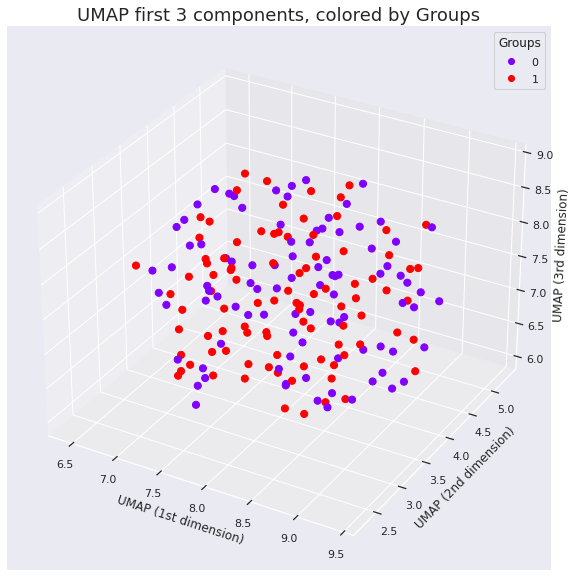

Corresponding labels for each class in legend : {'HCC': 0, 'HCC_Wide': 1, 'Non-case': 2}



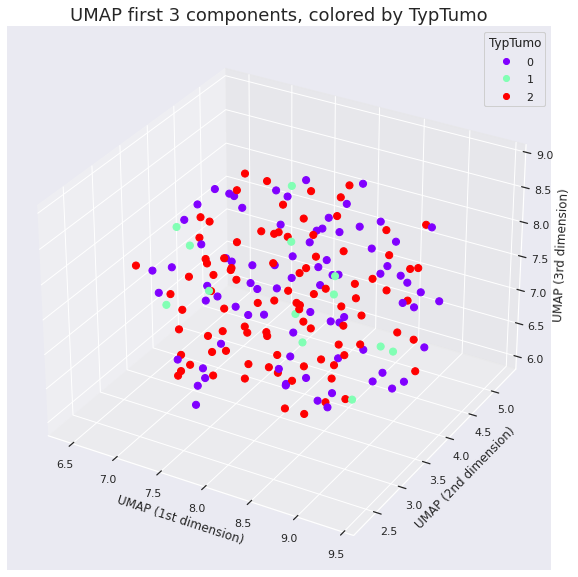

---------------------------------------------------------------------------------------------------- 



,SampleID,Groups,MatchCaseset,TypTumo,CaseHCCWide,EPICID,EPICBioID,AliquotID,UMAP1,UMAP2,UMAP3
0,LivCan_153,Incident,82,HCC,Yes,41____41041872,41____41041872,41041872-s2#C,8.992858,4.745321,8.165250
1,LivCan_154,Non-case,82,Non-case,No,41____41046868,41____41046868,41046868-s2#C,8.720459,4.589143,6.623544
2,LivCan_267,Incident,427,HCC,Yes,41____41074588,41____41074588,41074588-s1#B,7.981500,4.046450,8.897882
3,LivCan_268,Non-case,427,Non-case,No,41____41089214,41____41089214,41089214-s1#B,8.934326,4.736433,8.186306
4,LivCan_299,Incident,376,HCC_Wide,Yes,21____21103888,21____21103888,21103888-s1#B,8.700372,4.276911,6.613345
...,...,...,...,...,...,...,...,...,...,...,...
181,LivCan_080,Non-case,56,Non-case,No,32____3208004E,32____32253231,32253231-s3#C,8.168947,3.856640,8.303564
182,LivCan_375,Incident,383,HCC,Yes,22____22281416,22____22281416,22281416-s1#B,8.143383,4.296296,7.442866
183,LivCan_376,Non-case,383,Non-case,No,22____22281701,22____22281701,22281701-s1#B,7.033459,3.752634,7.545012
184,LivCan_165,Incident,147,HCC,Yes,71____71000825,71____71000065,71000065-s2#C,7.975939,4.273204,8.041510


In [166]:
print(100 * '#', '\n')

X_PCA, explained_variance = perform_PCA(X, part_explained_variance=0.95)
print(f'Initial number of dimension : {X.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(X_PCA)

print('\n', 100 * '#', '\n')

n_components = 3
peakTable_PCA_UMAP = perform_UMAP(X_PCA, metadata, n_components=n_components, targets_plot=targets, concat_metadata=True)
display(peakTable_PCA_UMAP)

In [168]:
filename = f'peakTable-PCA_95percent-UMAP_{n_components}comp.csv'
peakTable_PCA_UMAP.to_csv(path_peakTable_reduced + filename, header=True, index=False)
print(f'File {filename} saved in : {path_peakTable_reduced}')

File peakTable-PCA_95percent-UMAP_3comp.csv saved in : /home/jovyan/work/data/peakTable/reduced_peakTable/
